In [1]:
# Libraries

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np

import math

import scipy as sp
from scipy import optimize
from scipy.stats import ks_2samp

import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA as PCA

from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import resample

The columns containing outliers are: ['ESSILORLUXOTTICA' 'INDUSTRIA DE DISENO TEXTIL' 'KERING']
The rows containing outliers are on: ['2021-12-31T00:00:00.000000000']


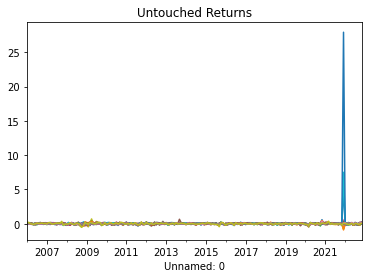

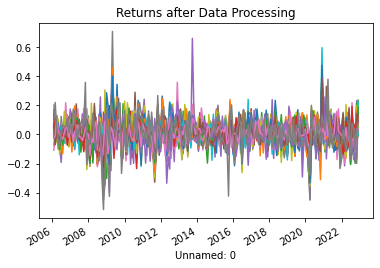

In [2]:
# Part 0) Data pre-processing

# 0.1 Import data

df_returns = pd.read_excel('DATA.xlsx')
df_returns['Unnamed: 0'] = pd.to_datetime(df_returns['Unnamed: 0'])
df_returns.set_index('Unnamed: 0', inplace=True)
df_returns.plot(legend=False, title = 'Untouched Returns')

# 0.2 Outliers identification

bool_df = (np.absolute(df_returns) > 1)

cols_with_outliers = bool_df.loc[:, bool_df.any()].columns
rows_with_outliers = df_returns[bool_df.any(axis=1)]

# 0.3 Filtering data

df_filtered = df_returns.drop(index = rows_with_outliers.index)

df_benchmark = df_filtered['ESTX 50 (EUR) NRt']
benchmark = np.array(df_benchmark)

df_filtered.drop(columns='ESTX 50 (EUR) NRt', inplace=True)
df_filtered.plot(legend=False, title = 'Returns after Data Processing')

print(f'The columns containing outliers are: {cols_with_outliers.values}')
print(f'The rows containing outliers are on: {rows_with_outliers.index.values}')

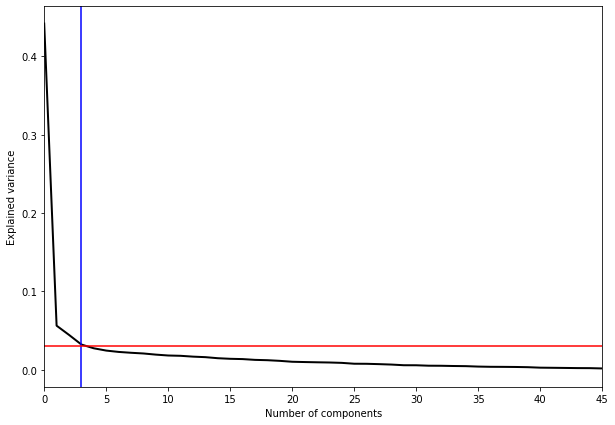

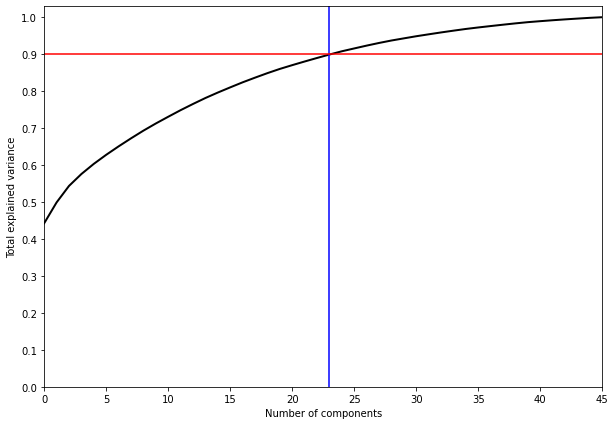

Correlation of first PC with benchmark index: 0.9812898344971389
Correlation of second PC with benchmark index: 0.04208971543088912
Correlation of third PC with benchmark index: -0.022638587980798257


In [3]:
# Part 1) Using PCA to retrieve implicit factors in our returns

# 1.1 PCA Transformation

# Normalization of the returns
returns_n = preprocessing.scale(df_filtered)

# Factorization of N components
pca_out = PCA(returns_n)

# Eigenvalues
pca_eval = pca_out.eigenvals

# Eigenvectors
pca_evec = pca_out.eigenvecs

# % of explained variance
pca_var = pca_eval/np.sum(pca_eval)

# Cumulated explained variance
pca_var_c = np.cumsum(pca_var)

# Principal components
pca_comp = pca_out.factors

# Correlation of principal components
corr = np.corrcoef(pca_comp,rowvar=0)


# 1.2 We now need to identify which factors to select:

# Criteria 1: Explained Variance plot

plt.figure(figsize=(10,7))
plt.plot(pca_var, color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.xlim(0, 45)
plt.yticks(np.arange(0, 0.5, 0.1))
plt.axvline(3, c='b')
plt.axhline(0.03, c='r')
plt.show();

# Criteria 2: Cumulative Explained Variance plot

plt.figure(figsize=(10,7))
plt.plot(pca_var_c, color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 45)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(23, c='b')
plt.axhline(0.9, c='r')
plt.show();

# Criteria 3: BAI And NG IC Criteria

pca_ic = pd.DataFrame(pca_out.ic)

# Because first PC is mainly negative we inverse its values

pca_comp[:,0] = -pca_comp[:,0]

# Correlation with first coeff

print(f'Correlation of first PC with benchmark index: {np.corrcoef(pca_comp[:,0], df_benchmark.values)[0][1]}')
print(f'Correlation of second PC with benchmark index: {np.corrcoef(pca_comp[:,1], df_benchmark.values)[0][1]}')
print(f'Correlation of third PC with benchmark index: {np.corrcoef(pca_comp[:,2], df_benchmark.values)[0][1]}')

In [5]:
# Part 2: Identification of the 𝑘i significant core factors (among the K latent factors)

returns = np.array(df_filtered)
principal_components = pca_comp[:,:3]
beta_l = np.zeros((returns.shape[1],principal_components.shape[1]))
# lambda_range = np.array([i for i in np.arange(1/1000,1,1/1000)])

# 2.1 Lasso regression

for i in range(returns.shape[1]):
    
    model_lasso = LassoCV(fit_intercept=True, normalize=False, cv=LeaveOneOut()) # could include alphas=lambda_range
    results_lasso = model_lasso.fit(principal_components,returns[:,i])
    beta_lasso=results_lasso.coef_
    beta_l[i,:] = beta_lasso

    
# 2.2 Data frames and plots


nmb_beta_unexp = [len(beta_l) - np.count_nonzero(beta_l[:,i]) for i in range(principal_components.shape[1])]
percent_beta_exp = [np.count_nonzero(beta_l[:,i]) / len(beta_l) for i in range(principal_components.shape[1])]
mean_beta_exp = [np.mean(beta_l[:,i]) for i in range(principal_components.shape[1])]

beta_exp = pd.DataFrame({'Number of Non significant Beta':nmb_beta_unexp,
                         'Percentage of Significant Beta':percent_beta_exp,
                         'Average Beta Exposure':mean_beta_exp}).T

print(beta_exp)

                                       0         1         2
Number of Non significant Beta  0.000000  4.000000  8.000000
Percentage of Significant Beta  1.000000  0.916667  0.833333
Average Beta Exposure           0.721321  0.005077  0.012534


Sum Weights of b1 = 1.0 and each weight is between -1 and 1.
Sum Weights of b2 = 1.0 and each weight is between -1 and 1.
Sum Weights of b3 = 1.0 and each weight is between -1 and 1.


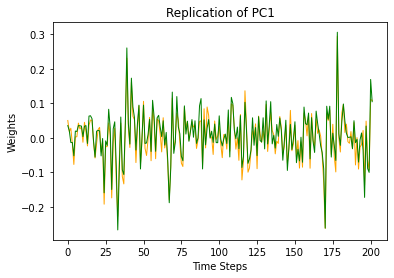

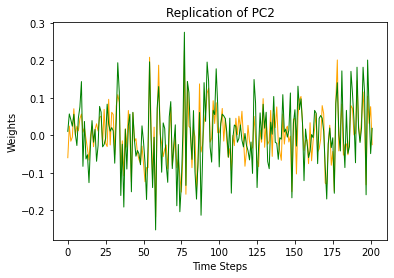

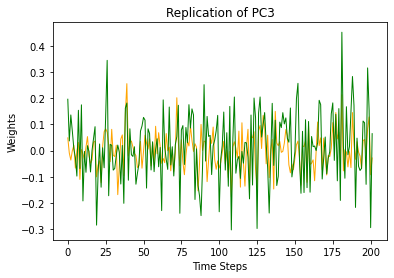

In [6]:
# Part 3: Weights of the K equity portfolios designed to replicate the K core equity factors


# 3.1. Volatility minimization with beta objective function

def port_minvol_bo(cov, beta, k, l, m):
    
    def objective(W, C, beta):
        
        # volatility of the portfolio
        
        vol=np.dot(np.dot(W.T,cov),W)**0.5
        util=vol
        
        return util
    
    # initial conditions: equal weights
    
    n = len(cov)
    W = np.ones([n])/n
    
    bounds = tuple((-1,1) for w in W)
    
    c_ = ({'type':'eq', 'fun': lambda W: np.sum(W)-1 },
         {'type':'eq', 'fun': lambda W: np.dot(W.T,beta[0,:].T)-k },
         {'type':'eq', 'fun': lambda W: np.dot(W.T,beta[1,:].T)-l },
         {'type':'eq', 'fun': lambda W: np.dot(W.T,beta[2,:].T)-m })
    
    optimized=sp.optimize.minimize(objective,W,(cov,beta),
                                      bounds=bounds, method='SLSQP',
                                   constraints=c_, options={'maxiter': 100, 'ftol': 1e-08})
    return optimized.x



# 3.2 Computing macro factor portfolio weights


cov = np.cov(returns, rowvar=0)

weights_b1 = port_minvol_bo(cov, beta_l.T, 1,0,0)
weights_b2 = port_minvol_bo(cov, beta_l.T, 0,1,0)
weights_b3 = port_minvol_bo(cov, beta_l.T, 0,0,1)

print(f'Sum Weights of b1 = {round(np.sum(weights_b1),2)} and each weight is between -1 and 1.')
print(f'Sum Weights of b2 = {round(np.sum(weights_b2),2)} and each weight is between -1 and 1.') 
print(f'Sum Weights of b3 = {round(np.sum(weights_b3),2)} and each weight is between -1 and 1.')

replication_PC1 = np.dot(returns,weights_b1.T)
replication_PC2 = np.dot(returns,weights_b2.T)
replication_PC3 = np.dot(returns,weights_b3.T)

replication_PC = [replication_PC1, replication_PC2, replication_PC3]

# 3.3 Plots of PC replication vs original PC

for i in range(len(replication_PC)):
    
    plt.figure(figsize=(6,4))
    plt.plot(pca_comp[:,i], color='orange', lw=1)
    plt.plot(replication_PC[i], color='green', lw=1)
    plt.xlabel('Time Steps')
    plt.ylabel('Weights')
    plt.title(f'Replication of PC{i+1}')
    plt.show();

# 3.4 Boundaries and Variance Portfolio data frames


min_values = [np.min(replication_PC1), np.min(replication_PC2), np.min(replication_PC3)]
max_values = [np.max(replication_PC1), np.max(replication_PC2), np.max(replication_PC3),]
variance_portfolio = [np.var(replication_PC1), np.var(replication_PC2), np.var(replication_PC3)]

boundaries_portfolio = pd.DataFrame({'Max Value':min_values,
                         'Min Value':max_values,
                         'Variance':variance_portfolio}).T

Optimization terminated successfully.
         Current function value: -2.245468
         Iterations: 50
         Function evaluations: 455
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: -1.008163
         Iterations: 32
         Function evaluations: 329
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: -0.633191
         Iterations: 33
         Function evaluations: 350
         Gradient evaluations: 50
            Alpha PC1  Alpha PC2  Alpha PC3
Unnamed: 0                                 
2006-01-31   0.004204   0.001866   0.013412
2006-02-28   0.004188   0.001867   0.013414
2006-03-31   0.004106   0.001867   0.013423
2006-04-28   0.004068   0.001868   0.013428
2006-05-31   0.004066   0.001869   0.013428
...               ...        ...        ...
2022-07-29  -0.002525   0.001863   0.013385
2022-08-31  -0.002996   0.001866   0.013409
2022-09-30  -0.003584   0.001867   0.0

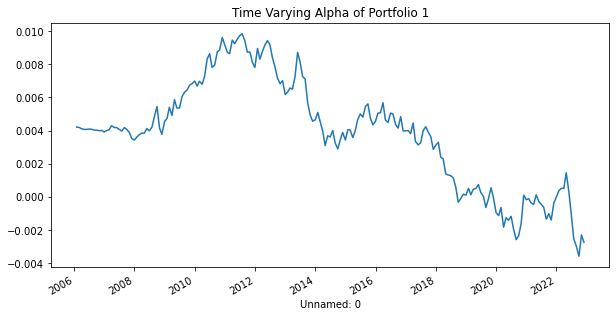

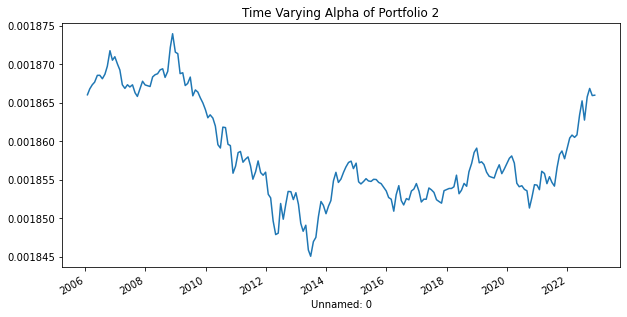

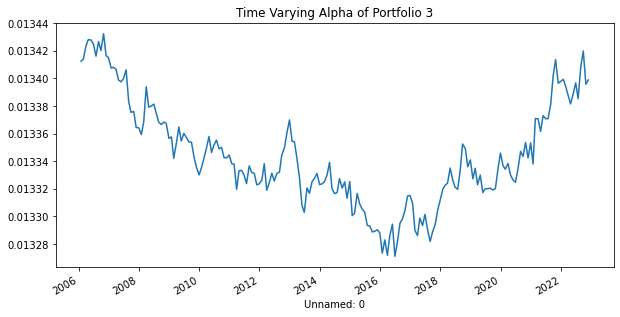

In [7]:
# Part 4) Time-varying alpha 𝛼̂𝑡

# 4.1 Kalman Filter Functions:

#VARIABLES GLOBALES
_Q=0
_H=0
_P0=0
_X0=0
_A=0
_Y=0
_Z=0
_nZ=0
_sr_ty=0
_sr_st=0
_C=0
_nU=0
_sr=0
out_opt=1

def Kalman(y,z,u):
    global _Q, _H, _Y, _Z, _X0, _P0, _A, _C, _U, _nZ, _nU, out_opt
    Y=y
    Z=z
    nZ=len(Z.T)
    #Vecteur des paramètres à estimer
    param=np.zeros((6))
    #INITIAL STATES
    X0=np.zeros((nZ,1))
    #INITIAL STATE COVARIANCE
    P0=np.eye(nZ)*10**6
    #TRANSITION MATRIX
    A=np.eye(nZ)
    #STATE INNOVATION COVARIANCE MATRIX
    Q=np.zeros((nZ,nZ))    
    #SIGNAL COVARIANCE MATRIX
    H=np.zeros((1,1))
    #CONTROL COEFFS  
    if np.isscalar(u)==1:
        U=0
        C=0
        nU=0
    else:
        U=u
        nU=len(U.T)
        C=np.zeros((nZ,nU))           
    #GLOBAL PARAMETERS
    _Q=Q
    _H=H
    _Y=Y
    _Z=Z
    _X0=X0
    _P0=P0
    _A=A
    _nZ=nZ
    _U=U
    _C=C
    _nU=nU    
    #OPTIMIZATION
    param=optimize.fmin_bfgs(ml_Multi,param,gtol=0.001)   
    #ESTIMATION WITH OPTIMIZED PARAMETERS
    H=np.exp(param[0])
    Q[0,0]=np.exp(param[1])
    X0[:,0]=param[2:4]
    P0[0,0]=np.exp(param[4])
    P0[1,1]=np.exp(param[5])
    (likely,XOUT,POUT,XOUTS)=kalman_filter(Y,Z,X0,P0,A,Q,H,U,C)
    return XOUT,XOUTS,POUT,param


def ml_Multi(param):    
    global _Q, _H, _Y, _Z, _X0, _P0, _A, _nZ, _C, out_opt
    param=param.reshape(6)
    _H=np.exp(param[0])
    _Q[0,0]=np.exp(param[1])
    _X0[:,0]=param[2:4]
    _P0[0,0]=np.exp(param[4])
    _P0[1,1]=np.exp(param[5])
    (likely,XOUT,POUT,XOUTS)=kalman_filter(_Y,_Z,_X0,_P0,_A,_Q,_H,_U,_C)
    return -likely

def kalman_filter(Y,Z,X0,P0,A,Q,H,U,C):
    #Y(T,1) Z(T,nZ) X0(nZ) P0(nZ,nZ) A(nZ,nZ) Q(nZ,nZ) H(1) U(T,nU) C(nZ,nU)
    nZ=len(Z.T)
    nT=len(Y)
    Xt=X0
    Pt=P0
    Zt=np.zeros((1,nZ))
    #-FOR FILTER
    Xout=np.zeros((nT,nZ))
    Pout=np.zeros((nT,nZ,nZ))
    #FOR SMOOTHER
    XoutS=np.zeros((nT,nZ))
    XtS=np.zeros((nT,nZ))
    Pt1t=np.zeros((nT,nZ,nZ))
    Ptt=np.zeros((nT,nZ,nZ))
    Xtt=np.zeros((nT,nZ))
    Xt1t=np.zeros((nT,nZ))
    
    l1=0.0
    l2=0.0
    likely=0.0
    #LOOP
    t=0
    while t<nT:
        #estimation step
        if np.isscalar(U)==1:
            Xte=A.dot(Xt)
        else:
            Xte=A.dot(Xt)+C.dot(U[t:t+1,:])
        Pte=A.dot(Pt).dot(A.T)+Q            
        #update
        Zt[:,:]=Z[t,:]
        vt=Y[t]-Zt.dot(Xte)
        Ft=Zt.dot(Pte).dot(Zt.T)+H
        Fti=np.linalg.inv(Ft)
        Xt=Xte+Pte.dot(Zt.T).dot(Fti).dot(vt)
        Pt=(np.eye(nZ)-Pte.dot(Zt.T).dot(Fti).dot(Zt)).dot(Pte)
        #stockage
        Xout[t,:]=Xt.T
        Pout[t,:,:]=Pt
        #pour smoother
        Ptt[t,:,:]=Pt
        Xtt[t,:]=Xt.T
        Pt1t[t,:,:]=Pte
        Xt1t[t,:]=Xte.T
        
        l1=l1+np.log(np.linalg.det(Ft))
        l2=l2+(vt.T).dot(Fti).dot(vt)
        t=t+1
    likely=-0.5*nT*np.log(2*math.pi)-0.5*l1-0.5*l2
    #SMOOTHER
    XtS[nT-1,:]=Xtt[nT-1,:]
    XoutS[nT-1,:]=Xtt[nT-1,:]
    for t in range(nT-2,-1,-1):
        inverse=np.linalg.inv(Pt1t[t+1,:,:])
        Ft=Ptt[t,:,:].dot(A.T).dot(inverse)
        XtS[t,:]=Xtt[t,:]+Ft.dot(XtS[t+1,:]-Xt1t[t+1,:])
        XoutS[t,:]=XtS[t,:]
    likely=np.reshape(likely,(1))
    return likely/nT,Xout,Pout,XoutS


# 4.2 Estimation of time varying alpha using Kalman Filter

benchmarks = benchmark.reshape(len(benchmark),1)

c = np.ones((len(benchmark),1))

alphas = np.ones((len(benchmark),principal_components.shape[1]))

portfolios = [replication_PC1, replication_PC2, replication_PC3]
    
# Time Varying alpha

for i in range(len(portfolios)):
    
    output = Kalman(portfolios[i], np.concatenate((c,benchmarks),axis=1), 0)
    alphas[:,i] = output[0][:,0]

# Data Frame and plots
    
df_alphas = pd.DataFrame({'Alpha PC1':alphas[:,0], 'Alpha PC2':alphas[:,1], 
                          'Alpha PC3':alphas[:,2]}, index=df_benchmark.index)

print(df_alphas)

# Plots
for i in range(len(df_alphas.columns)):
    
    df_alphas.iloc[:,i].plot(title= f'Time Varying Alpha of Portfolio {i+1}', figsize = (10,5))
    plt.show()

Optimization terminated successfully.
         Current function value: -2.268382
         Iterations: 52
         Function evaluations: 448
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -2.268382
         Iterations: 52
         Function evaluations: 448
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -2.268382
         Iterations: 52
         Function evaluations: 448
         Gradient evaluations: 64


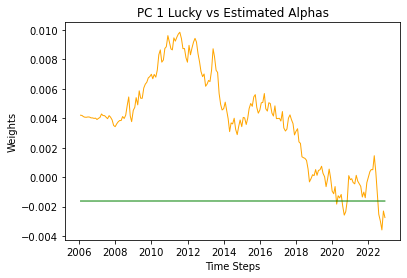

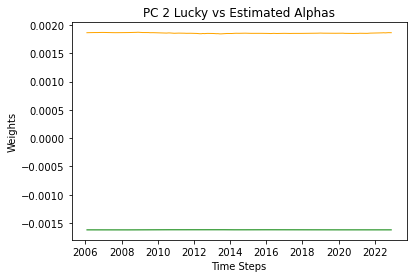

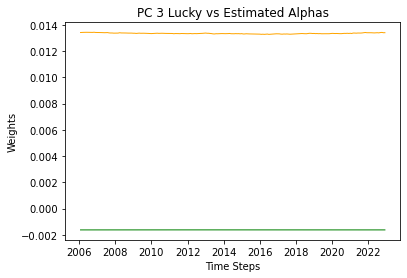

               Statistic  P-value
KS Test - PC1       0.96      0.0
KS Test - PC2       1.00      0.0
KS Test - PC3       1.00      0.0


In [9]:
#Part 5: Kolmogorov Smirnov Test on the bootstrapped returns

# variable creation

beta_o = []
residuals = []
residuals_bootstraped = []
port_returns_boot = []
output_boot = []
alpha_boot = []
smirnov = []


for i in range(len(portfolios)):
    
    #Finding constant beta with OLS
    
    model_ols = sm.OLS(portfolios[i],benchmarks).fit()
    beta_o.append(model_ols.params[0])
    residuals.append(portfolios[i] - (alphas[:,i] + beta_o[i]*benchmark))
    
    #Resampling Estamated Residuals of Kalman Filter
    
    residuals_bootstraped.append(resample(residuals[i], replace=True))
                     
    #Computing Bootstrapped sample retunrs for which the alpha is null
    
    port_returns_boot.append(beta_o[i]*benchmark + residuals[i])
    
    #Recomputing the rolling window alpha using the Kalman Filter on the bootstrapped returns
                     
    output_boot.append(Kalman(port_returns_boot[0], np.concatenate((c,benchmarks),axis=1),0))  
    
    #Extracting the statisically null alphas
    
    alpha_boot.append(output_boot[i][0][:,0])
    
    #Running Kolmogorov Smirnov Test all the portfolios
    
    smirnov.append(ks_2samp(alphas[:,i], alpha_boot[i]))

# Data Frame

df_ks_test = pd.DataFrame.from_dict({"KS Test - PC1": [round(smirnov[0][0],2),round(smirnov[0][1],0)],
"KS Test - PC2": [round(smirnov[1][0],2),round(smirnov[1][1],0)],
"KS Test - PC3": [round(smirnov[2][0],2),round(smirnov[2][1],0)]}, orient = 'index',columns=["Statistic","P-value"])

df_lucky_alphas = pd.DataFrame({'Lucky Alpha PC1':alpha_boot[0], 'Lucky Alpha PC2':alpha_boot[1], 
                          'Lucky Alpha PC3':alpha_boot[2]}, index=df_benchmark.index)

# Plots and print df

for i in range(len(df_lucky_alphas.columns)):
    
    plt.figure(figsize=(6,4))
    plt.plot(df_alphas.iloc[:,i], color='orange', lw=1, label= 'Estimated Alphas')
    plt.plot(df_lucky_alphas.iloc[:,i], color='green', lw=1, label= 'Lucky Alphas')
    plt.xlabel('Time Steps')
    plt.ylabel('Weights')
    plt.title('Replication of PC3')
    plt.title(f'PC {i+1} Lucky vs Estimated Alphas')
    plt.show()
    
print(df_ks_test)